In [1]:
!pip install -Uqq pytorch-lightning==1.0.0 omegaconf
!pip install -Uqq git+https://github.com/albumentations-team/albumentations
!pip uninstall torchtext
!git clone https://github.com/benihime91/pytorch_retinanet.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.4/510.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 

In [2]:
#Update sys path to include the pytorch RetinaNet modules
import warnings
import os
import sys

warnings.filterwarnings('ignore')
sys.path.append("/content/pytorch_retinanet/")
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#Downloading data from Roboflow
#UPDATE THIS LINK - get our data from Roboflow
%cd /content
!curl -L "https://universe.roboflow.com/ds/shsAeiRm8U?key=joNHRgAHlk" > roboflow.zip; unzip -qq roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   3379      0 --:--:-- --:--:-- --:--:--  3374
100  101M  100  101M    0     0  49.9M      0  0:00:02  0:00:02 --:--:-- 78.5M


In [4]:
#Set up paths

#Path to where the Images are stored
TRAIN_IMAGE_PATH = "/content/train/"
VALID_IMAGE_PATH = "/content/valid/"
TEST_IMAGE_PATH  = "/content/test/"
#Path to where annotations are stored
TRAIN_ANNOT_PATH = "/content/train/"
VALID_ANNOT_PATH = "/content/valid/"
TEST_ANNOT_PATH  = "/content/test/"

In [5]:
import pandas as pd
from PIL import Image
import cv2
import numpy as np

from utils.pascal import convert_annotations_to_df

pd.set_option("display.max_colwidth", None)
np.random.seed(123)

In [6]:
#convert xml files to pandas DataFrames
train_df = convert_annotations_to_df(TRAIN_ANNOT_PATH, TRAIN_IMAGE_PATH, image_set="train")
valid_df = convert_annotations_to_df(VALID_ANNOT_PATH, VALID_IMAGE_PATH, image_set="test")
test_df  = convert_annotations_to_df(TEST_ANNOT_PATH, TEST_IMAGE_PATH, image_set="test")


def remove_invalid_annots(df):
    """
    Removes annotations where xmax, ymax < xmin,ymin
    from the given dataframe
    """
    df = df[df.xmax > df.xmin]
    df = df[df.ymax > df.ymin]
    df.reset_index(inplace=True, drop=True)
    return df

# removing annotations that are not valid annotations
train_df = remove_invalid_annots(train_df)
valid_df = remove_invalid_annots(valid_df)
test_df  = remove_invalid_annots(test_df)

In [7]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/train/IMG_20191227_151411_jpg.rf.56ea9be08426827457432fde4cd4dabe.jpg,1536,2048,PETE,387,15,1157,1516,3
1,/content/train/IMG_20191227_151411_jpg.rf.56ea9be08426827457432fde4cd4dabe.jpg,1536,2048,HDPE,485,1529,943,1826,1
2,/content/train/3af5c612be4aec418352019ec398efff_jpg.rf.943daf18942d66e56bf27ea768f84e1b.jpg,736,736,PS,95,216,615,530,5
3,/content/train/00000015_jpg.rf.4404a14f70a02eef9edfaf8b718a5bd1.jpg,800,800,PP,1,1,661,801,4
4,/content/train/0f7cb25b48495908d05a9acee8b6f4d8_jpg.rf.aab49bebb943de66c55a96ff63a29caf.jpg,1600,900,PVC,193,1,1295,885,6


In [8]:
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/test/2df7deb6a8707d7a5bed1aa37ea4c743_jpg.rf.747dba764334cb988af38f33b4d34498.jpg,564,564,HDPE,170,4,413,297,1
1,/content/test/2df7deb6a8707d7a5bed1aa37ea4c743_jpg.rf.747dba764334cb988af38f33b4d34498.jpg,564,564,PP,176,290,434,565,4
2,/content/test/131a43de9b46fe4fb019a7094c635f52_jpg.rf.a67778330f863f496dd233811f26cf36.jpg,564,564,PVC,10,12,331,381,6
3,/content/test/131a43de9b46fe4fb019a7094c635f52_jpg.rf.a67778330f863f496dd233811f26cf36.jpg,564,564,PVC,280,198,565,546,6
4,/content/test/df8d2a9d11e877c99acd7bfdb5cbbe6a_jpg.rf.52ac67e7a1cbf14ce8e721c30579b953.jpg,564,564,PVC,34,8,547,565,6


In [9]:
valid_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/valid/trash60_jpg.rf.fb163d161490593a76c601e0436ccfb2.jpg,512,384,PS,91,8,422,385,5
1,/content/valid/Kemasan_jpg.rf.7e342251a9a8a3f308c01f63328bd49a.jpg,650,433,PETE,524,201,614,434,3
2,/content/valid/Kemasan_jpg.rf.7e342251a9a8a3f308c01f63328bd49a.jpg,650,433,PETE,426,167,516,434,3
3,/content/valid/Kemasan_jpg.rf.7e342251a9a8a3f308c01f63328bd49a.jpg,650,433,PETE,397,288,469,434,3
4,/content/valid/Kemasan_jpg.rf.7e342251a9a8a3f308c01f63328bd49a.jpg,650,433,PETE,348,247,409,400,3


In [10]:
#Paths where to save the generated dataframes
TRAIN_CSV = "/content/train_data.csv"
VALID_CSV = "/content/valid_data.csv"
TEST_CSV  = "/content/test_data.csv"

# #Save the dataframes to memory
train_df.to_csv(TRAIN_CSV, index=False)
valid_df.to_csv(VALID_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)

In [11]:
train_df = pd.read_csv(TRAIN_CSV)
valid_df = pd.read_csv(VALID_CSV)
test_df  = pd.read_csv(TEST_CSV)

In [12]:
from utils.pascal import generate_pascal_category_names

LABEL_MAP = generate_pascal_category_names(train_df)
LABEL_MAP

['__background__', 'HDPE', 'LDPE', 'PETE', 'PP', 'PS', 'PVC']

In [49]:
from utils import visualize_boxes_and_labels_on_image_array as viz_bbs
import matplotlib.pyplot as plt


def grab_bbs_(dataframe, index:int):
    """
    Takes in a Pandas DataFrame and a index number
    Returns filename of the image and all the bounding boxes and class_labels
    corresponding the image that is at the given index

    Params
    ------
        dataframe : a pandas dataframe object
        index (int) : a integer corresponding to a index in the pandas dataframe

    Returns
    -------
        fname (str) : path to the selected image.
        bbbs (list) : a list containing the bounding box annotations for the `fname`.
        cls (list) : a list containing the integer class labels for the box annotations.
    """
    assert index <= len(dataframe), f"Invalid index for dataframe with len: {len(dataframe)}"
    fname = dataframe.filename[index]
    locs  = dataframe.loc[dataframe.filename == fname]
    bbs   = locs[["xmin", "ymin", "xmax", "ymax"]].values
    cls   = locs["labels"].values

    return fname, bbs, cls


def load_image_from_data(dataframe, index):
    """
    Loads in a image from the given dataframe at given index
    Returns a PIL image object contraining all the bounding boxes over
    the image
    """
    image, boxes, clas = grab_bbs_(dataframe, index)
    #load and normalize the image
    image = Image.open(image)
    image = np.array(image) / 255.
    boxes = np.round(boxes).astype(int)
    image = viz_bbs(image, boxes, scores=None, classes=clas, label_map=LABEL_MAP)
    return image

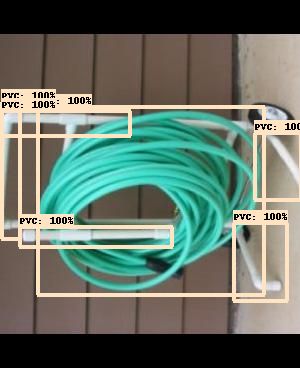

In [56]:
image = load_image_from_data(train_df, index=100)
image

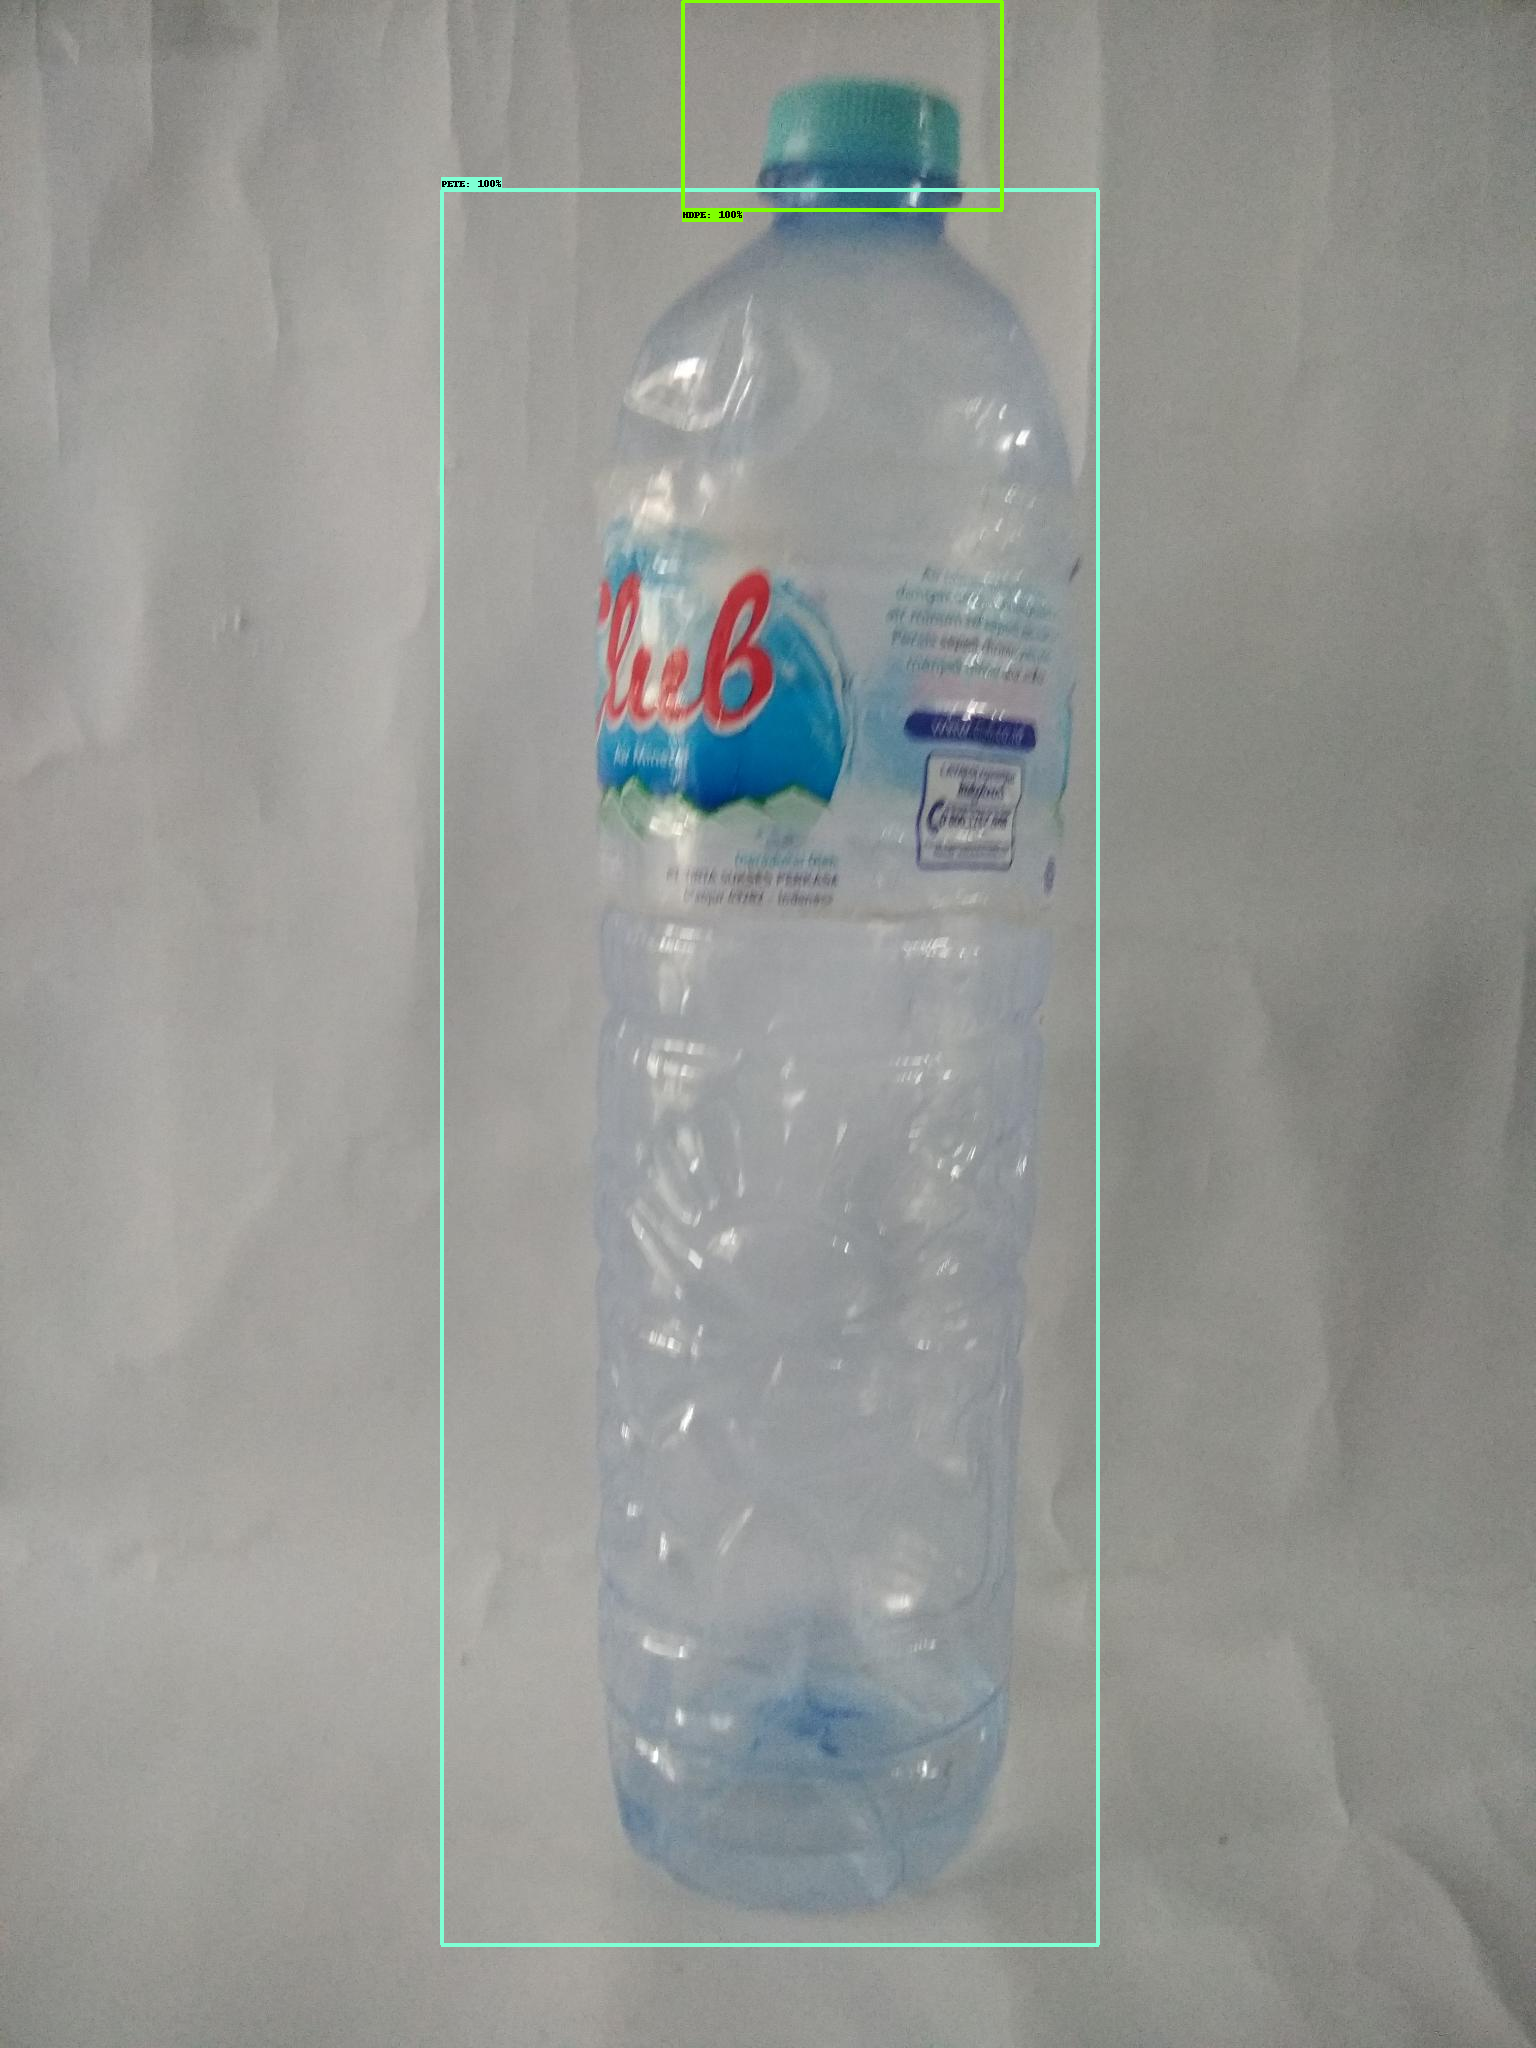

In [60]:
image = load_image_from_data(valid_df, index=100)
image

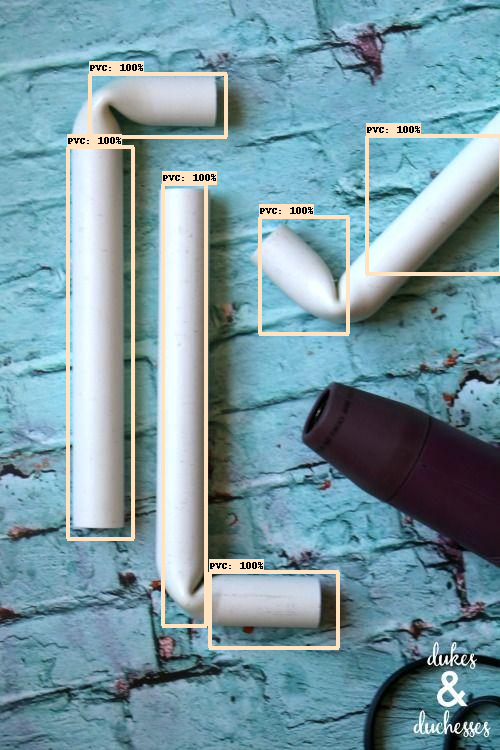

In [58]:
image = load_image_from_data(test_df, index=40)
image

In [63]:
NUM_TRAIN_EPOCHS = 10


from omegaconf import OmegaConf

#load in the hparams.ymal file using Omegaconf
hparams = OmegaConf.load("/content/pytorch_retinanet/hparams.yaml")

# ========================================================================= #
# MODIFICATION OF THE CONFIG FILE TO FIX PATHS AND DATSET-ARGUEMENTS :
# ========================================================================= #
hparams.dataset.kind        = "csv"
hparams.dataset.trn_paths   = TRAIN_CSV
hparams.dataset.valid_paths = VALID_CSV
hparams.dataset.test_paths  = TEST_CSV

hparams.dataloader.train_bs = 1
hparams.dataloader.valid_bs = 16
hparams.dataloader.test_bs  = 16

hparams.model.num_classes   = len(LABEL_MAP) - 1
hparams.model.backbone_kind = "resnet34"
hparams.model.min_size      = 800
hparams.model.max_size      = 1333
hparams.model.pretrained    = True #loads in imagenet-backbone weights

#transforms for the train_dataset
hparams.transforms  =  [
    {"class_name": "albumentations.HorizontalFlip", "params": {"p": 0.5} },
    {"class_name": "albumentations.ShiftScaleRotate", "params": {"p": 0.5} },
    {"class_name": "albumentations.RandomBrightnessContrast", "params": {"p": 0.5} },
]

#optimizer
hparams.optimizer = {
    "class_name": "torch.optim.SGD",
    "params"    : {"lr": 0.001, "weight_decay": 0.0005, "momentum":0.9},
    }

#scheduler
hparams.scheduler = {
    "class_name" : "torch.optim.lr_scheduler.CosineAnnealingLR",
    "params"     : {"T_max": NUM_TRAIN_EPOCHS},
    "monitor"    : None,
    "interval"   : "epoch",
    "frequency"  : 1
    }

print(OmegaConf.to_yaml(hparams))

model:
  backbone_kind: resnet34
  num_classes: 6
  freeze_bn: true
  min_size: 800
  max_size: 1333
  pretrained: true
dataset:
  kind: csv
  root_dir: false
  trn_paths: /content/train_data.csv
  valid_paths: /content/valid_data.csv
  test_paths: /content/test_data.csv
dataloader:
  train_bs: 1
  valid_bs: 16
  test_bs: 16
  args:
    num_workers: 0
    pin_memory: true
transforms:
- class_name: albumentations.HorizontalFlip
  params:
    p: 0.5
- class_name: albumentations.ShiftScaleRotate
  params:
    p: 0.5
- class_name: albumentations.RandomBrightnessContrast
  params:
    p: 0.5
optimizer:
  class_name: torch.optim.SGD
  params:
    lr: 0.001
    weight_decay: 0.0005
    momentum: 0.9
scheduler:
  class_name: torch.optim.lr_scheduler.CosineAnnealingLR
  params:
    T_max: 10
  monitor: null
  interval: epoch
  frequency: 1



In [64]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping

from model import RetinaNetModel

pl.seed_everything(70)

70

In [65]:
# ============================================================ #
# INSTANTIATE LIGHTNING-TRAINER with CALLBACKS :
# ============================================================ #
# NOTE:
# For a list of whole trainer specific arguments see :
# https://pytorch-lightning.readthedocs.io/en/latest/trainer.html

lr_logger  = LearningRateMonitor(logging_interval="step")

#instantiate LightningTrainer
trainer    = Trainer(precision=16, gpus=1, callbacks=[lr_logger], max_epochs=NUM_TRAIN_EPOCHS)

GPU available: True, used: True
INFO:retinanet.models:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:retinanet.models:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:retinanet.models:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:retinanet.models:Using native 16bit precision.


In [66]:
# Instantiate lightning-module
litModel = RetinaNetModel(conf=hparams)

BACKBONE     : resnet34
INFO:retinanet.models:BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
INFO:retinanet.models:INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
NUM_CLASSES  : 6
INFO:retinanet.models:NUM_CLASSES  : 6


In [67]:
trainer.fit(litModel)


  | Name | Type      | Params
-----------------------------------
0 | net  | Retinanet | 29 M  
INFO:retinanet.models:
  | Name | Type      | Params
-----------------------------------
0 | net  | Retinanet | 29 M  


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [69]:
trainer.test(litModel)

[autoreload of torch failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.10/dist-packages/torch/__init__.py", line 533, in <module>
    for name in dir(_C):
NameError: name '_C' is not defined
]


creating index...
index created!


Testing: 0it [00:00, ?it/s]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

[{'AP': 0.5504950495049505}]

In [81]:
import torch
PATH = f"/content/trained_weights.pth"
torch.save(litModel.net.state_dict(), PATH)

In [82]:
import logging
logger = logging.getLogger("lightning")

In [83]:
from retinanet import Retinanet

#load saved model state dict
state_dict = torch.load(PATH)
#model arguments same as the arguments used to train the model
model_args = hparams.model
#load pytorch model without the lightning-module
#using args and state dict
MODEL      = Retinanet(**model_args, logger=logger)
MODEL.load_state_dict(state_dict)
MODEL.eval()
MODEL.to("cuda:0");

BACKBONE     : resnet34
INFO:retinanet.models:BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
INFO:retinanet.models:INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
NUM_CLASSES  : 6
INFO:retinanet.models:NUM_CLASSES  : 6


In [106]:
from PIL import Image
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

@torch.no_grad()
def get_preds(path, threshold=0.6,):
    """
    Generates predictions on the given image from the given path.

    Params
    ------
        image_path (str) : Path to the input Image
        threshold (float): Score threshold to filter predictions

    Returns
    -------
        A Dictionary contatining the predictions from generated from the model on
        the given image.
        Keys of the dictionary:
          - "boxes" : bounding-box co-ordinates
          - "labels": class labels for the bounding box co-ordinates.
          - "scores": scores for the bounding box co-ordinates.
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

    INFER_TRANSFORMS = A.Compose([
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True)
        ])

    TENSOR_IMAGE = INFER_TRANSFORMS(image=image)["image"].to("cuda:0")
    PREDICTIONS  = MODEL.predict([TENSOR_IMAGE])
    return PREDICTIONS[0]

def detect(image_path, threshold=0.6):
    """
    Generate detections on the image that is present in
    the given image path

    Params
    ------
        image_path `(str)` : Path to the input Image
        threshold `(float)`: Score threshold to filter predictions

    Returns
    -------
        boxes  `(np.array)`: filtered absolute bounding box co-ordinates.
        labels `(np.array)`: class labels for the bounding box co-ordinates.
        scores `(np.array)`: scores for the bounding box co-ordinates.
    """
    # Generate predictions for the given image
    preds = get_preds(image_path, threshold,)
    #print(preds)
    # Filter predictions
    boxes, labels, scores = preds["boxes"], preds["labels"], preds["scores"]
    mask   = scores > threshold
    boxes  = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    return boxes.cpu().numpy(), labels.cpu().numpy(), scores.cpu().numpy()

def draw_on_image(image_path, boxes, scores, classes, label_map=LABEL_MAP):
    """
    Draw bounding box over the image at image path, with the scores and classes
    Returns a PIL image object.

    Params
    ------
        image_path `(str)`   : Path to the input Image
        boxes `(List[N,4])`  : absolute bouding box co-ordiates in the form `[xmin,ymin,xmax,ymax]`.
        scores `(List[N])`   : List containing the scores for each of the bounding box.
        classes `(`List[N])` : List containing the class_labels for each of the bounding box.
        label_map `(List)`   : List of the labels

    Returns
    -------
        A PIL Image object
    """
    image = Image.open(image_path)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=scores, classes=classes, label_map=LABEL_MAP)
    return image

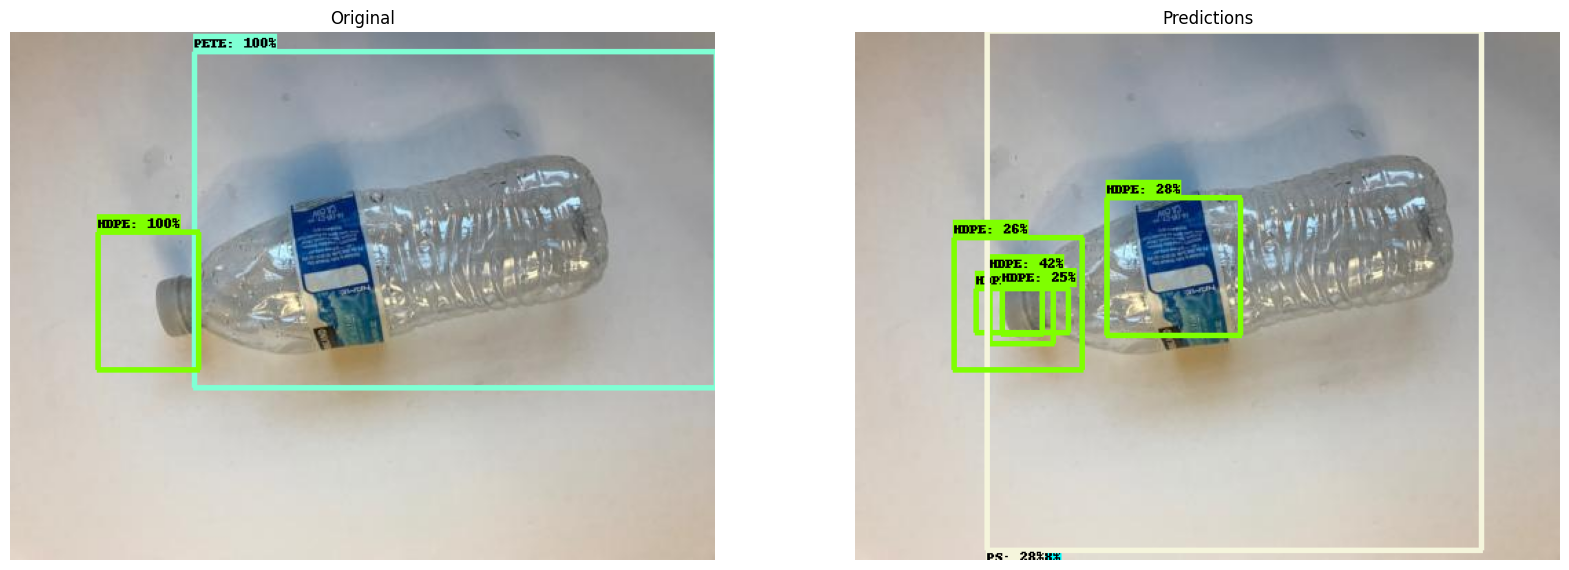

In [115]:
idx = np.random.randint(len(test_df))

#Path to the image
image_path = test_df.filename[idx]
#generate predictions for the image
boxes, labels, scores = detect(image_path,threshold=0.25)

pred_image = draw_on_image(image_path, boxes, scores, labels)

real_image = load_image_from_data(test_df, index=idx)


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

ax1.imshow(real_image)
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(pred_image)
ax2.set_title("Predictions")
ax2.axis("off");

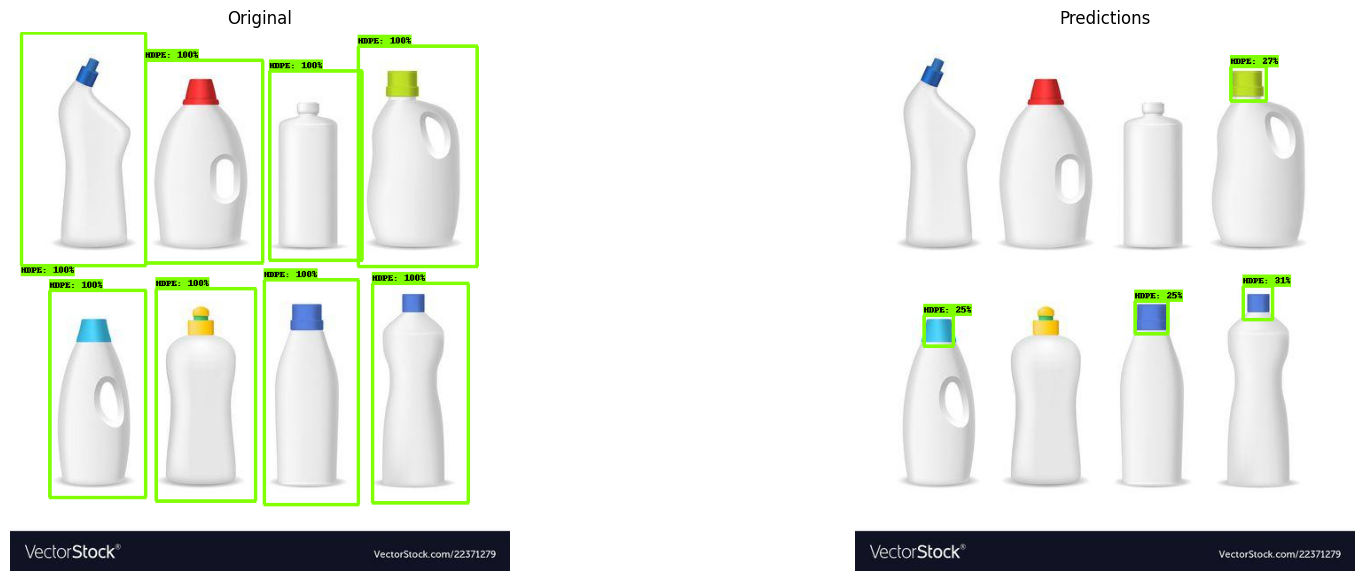

In [116]:
idx = np.random.randint(len(test_df))

#Path to the image
image_path = test_df.filename[idx]
#generate predictions for the image
boxes, labels, scores = detect(image_path, threshold=0.25)

pred_image = draw_on_image(image_path, boxes, scores, labels)

real_image = load_image_from_data(test_df, index=idx)


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

ax1.imshow(real_image)
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(pred_image)
ax2.set_title("Predictions")
ax2.axis("off");